Loading and Preprocessing the Data

In [3]:
#Libraries Used
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import keras_tuner as kt

#Specific Libraries Used
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#Loading the Dataset
data_dir = "./Images 2"

#Configuring the Dataset
batch_size = 32 #number of samples processed at one time
img_height = 180 #image dimensions
img_width = 180 

#Training the Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, "Training"),
    labels = "inferred", #infer labels from folder names
    label_mode = "categorical", #use one-hot encoding for labels
    validation_split=0.2, #use 80% of the data for training
    subset="training",
    seed=123, #seed for shuffling the data 
    image_size=(img_height, img_width),
    batch_size=batch_size
)

#Validating the Dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "Training"), 
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2, # Use 20% of the data for validation
    subset="validation",
    seed=123,           
    image_size=(img_height, img_width),
    batch_size=batch_size
)

#Testing the Dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, "Testing"),
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

#Get class names
class_names = train_ds.class_names
print(f"Found {len(class_names)} classes: {class_names}")

#Preprocessing & Data Augmentation layers
normalization_layer = layers.Rescaling(1./255) #normalise pixel values to [0,1] from [0,255]
data_augmentation = keras.Sequential([  #to prevent overfitting by increasing dataset size, making it more robust
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

#Apply Preprocessing & Data Augmentation layers to the datasets
AUTOTUNE = tf.data.AUTOTUNE #for performance optimization

# Training Dataset Pipeline: Cache -> Shuffle -> Augmentation -> Prefetch
train_ds = train_ds.cache().shuffle(buffer_size=1000) # Cache the normalized data, then shuffle it

# Apply augmentation cache and shuffle, using .map() for element-wise transformation
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE) # Prefetch the next batch

# Validation Dataset Pipeline: Cache -> Prefetch (No Shuffle, No Augmentation)
val_ds = val_ds.cache() # Cache the normalized data
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE) # Prefetch the next batch

# Testing Dataset Pipeline: Normalization -> Cache -> Prefetch (No Shuffle, No Augmentation)
test_ds = test_ds.cache() # Cache the normalized data
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE) # Prefetch the next batch


print("\nDatasets preprocessed, optimized, and ready.")
print(f"Training dataset pipeline: {train_ds}")
print(f"Validation dataset pipeline: {val_ds}")
print(f"Testing dataset pipeline: {test_ds}")


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
Found 4 classes: ['glioma', 'meningioma', 'notumor', 'pituitary']

Datasets preprocessed, optimized, and ready.
Training dataset pipeline: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
Validation dataset pipeline: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
Testing dataset pipeline: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


Defining the model

In [4]:
num_classes = len(class_names) #number of classes

def build_model(hp):
  model = Sequential([ #linear stack of layers
  data_augmentation, #data augmentation layer from above
  normalization_layer, #normalise pixel values to [0,1] from [0,255]
  ])
  #convolutional blocks with tunable filters

  #1st conv layer
  hp_filters_1 = hp.Int('conv_1_filters', min_value=16, max_value=64, step=16)
  model.add(layers.Conv2D(hp_filters_1, 3, padding='same', activation='relu')) # Use chosen filters: 16 filters (more filters = more features), 3x3 kernel (filter size), same padding (output feature map has same spatial dimensions), relu activation (introduce non-linearity)
  model.add(layers.MaxPooling2D()) #reduce spatial dimensions

  #2nd conv layer
  hp_filters_2 = hp.Int('conv_2_filters', min_value=32, max_value=128, step=32)
  model.add(layers.Conv2D(hp_filters_2, 3, padding='same', activation='relu')) # Use chosen filters: 32 filters, 3x3 kernel, padding, activation
  model.add(layers.MaxPooling2D()) #reduce spatial dimensions

  #3rd conv layer
  hp_filters_3 = hp.Int('conv_3_filters', min_value=64, max_value=256, step=64)
  model.add(layers.Conv2D(hp_filters_3, 3, padding='same', activation='relu')) # Use chosen filters: 64 filters, 3x3 kernel, padding, activation
  model.add(layers.MaxPooling2D()) #reduce spatial dimensions

  #dropout layer to prevent overfitting
  hp_dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
  model.add(layers.Dropout(hp_dropout_rate)) #randomly set dropout rate to prevent overfitting

  model.add(layers.Flatten()) # Prepare for dense layers

  #dense layers with tunable neurons
  hp_dense_units = hp.Int('dense_units', min_value=64, max_value=512, step=64)
  model.add(layers.Dense(hp_dense_units, activation='relu')) #fully connected layer with tunable neurons and relu activation to every previous layer

  #output layer
  model.add(layers.Dense(num_classes, activation = "softmax" ,name="outputs")) # This is the output layer, uses probability distribution for multi-class classification, num_classes is the number of classes in the dataset

  #tune the optimizer
  hp_optimizer = hp.Choice('optimizer', values=['adam', 'sgd']) # Choose optimizer
  if hp_optimizer == 'adam':
    hp_learning_rate = hp.Float('adam_learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate) #find the best learning rate
  elif hp_optimizer == 'sgd':
    hp_learning_rate = hp.Float('sgd_learning_rate', min_value=1e-3, max_value=1e-1, sampling='log')
    optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)
  else: # Fallback if optimizer isn't one of the choices (shouldn't happen with hp.Choice)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

  #compiling the model
  model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])#categorical crossentropy loss function for multi-class classification
  return model    


Hyperparameterising the Model

In [5]:
#choose a tuner
tf.keras.backend.clear_session()
print("Keras backend session cleared.")

tuner = kt.Hyperband(
    hypermodel = build_model, #function to build the model
    objective='val_accuracy', #objective to optimize
    max_epochs=20, #maximum number of epochs to train the model
    factor=3, #factor for reducing the number of models to train in each round
    directory='tuner_dir', #directory to save the tuner results
    project_name='hyperband_tuning', #project name for the tuner results
    overwrite=False #overwrite the directory if it already exists
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    patience=5,         # Stop if val_loss doesn't improve for 5 epochs
    restore_best_weights=True # Restore weights from the epoch with the best val_loss
)

tuner.search(
    train_ds, #training dataset
    epochs=20, #number of epochs to train the model
    validation_data=val_ds, #validation dataset
    callbacks=[early_stopping] #early stopping callback to prevent overfitting
)
print("\nKeras Tuner search complete.")

# Print the best hyperparameters found
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0] # Get top 1 trial

print(f"""
The hyperparameter search has identified the best settings:
- Conv 1 Filters: {best_hps.get('conv_1_filters')}
- Conv 2 Filters: {best_hps.get('conv_2_filters')}
- Conv 3 Filters: {best_hps.get('conv_3_filters')}
- Dropout Rate: {best_hps.get('dropout_rate')}
- Dense Units: {best_hps.get('dense_units')}
- Optimizer: {best_hps.get('optimizer')}
- Learning Rate: {best_hps.get(f'{best_hps.get("optimizer")}_learning_rate')}
""")

# Get the best model found (already compiled)
best_model = tuner.get_best_models(num_models=1)[0]



Keras backend session cleared.
Reloading Tuner from tuner_dir\hyperband_tuning\tuner0.json

Keras Tuner search complete.

The hyperparameter search has identified the best settings:
- Conv 1 Filters: 16
- Conv 2 Filters: 64
- Conv 3 Filters: 128
- Dropout Rate: 0.4
- Dense Units: 192
- Optimizer: adam
- Learning Rate: 0.0003932349742095787



C:\Users\steph\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training the Model

In [6]:
epochs = 20 #number of epochs to train the model

history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

Epoch 1/20


KeyboardInterrupt: 

Visualising the Results


Model training complete.


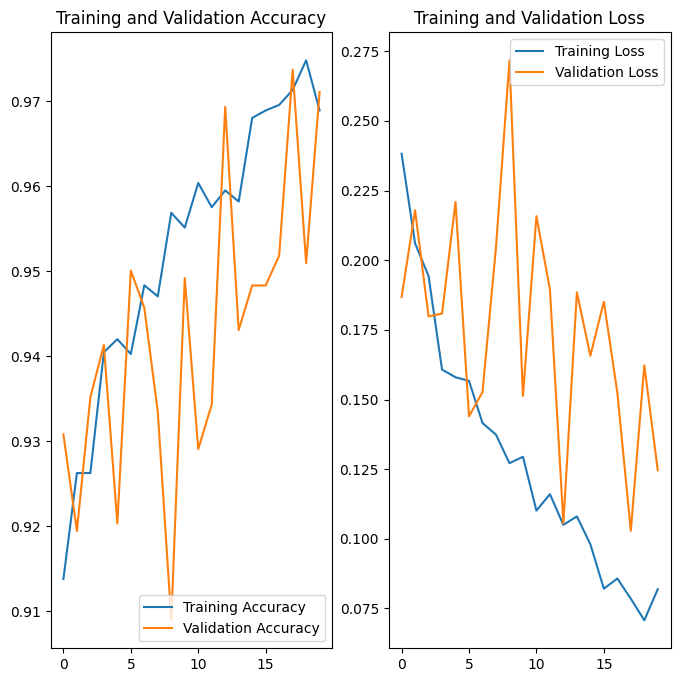

In [ ]:
print("\nModel training complete.")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_actually_run = len(acc) #number of epochs actually run
epochs_range = range(epochs_actually_run) #range of epochs actually run

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Saving the model

In [ ]:
import time
t = time.time()

export_path = "models/saved_models/{}.keras".format(int(t)) # Save the model in Keras format
export_dir = os.path.dirname(export_path) # Get the directory name from the path
os.makedirs(export_dir, exist_ok=True) # Create the directory if it doesn't exist
best_model.save(export_path) # Save the model to the specified path

print(f"Model successfully saved to: {export_path}")

Model successfully saved to: models/saved_models/1746955898.keras


Results of the best model

In [ ]:
reloaded = tf.keras.models.load_model(export_path) # Load the model from the saved path
val_loss, val_accuracy = reloaded.evaluate(val_ds) # Evaluate the model on the validation dataset
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}") 



36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9768 - loss: 0.1023
Validation Loss: 0.12458375096321106, Validation Accuracy: 0.971103310585022


Evaluating the model with test data

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

#prepare test dataset
test_ds_prepared = test_ds.cache()        # Cache data after loading/batching for faster access
test_ds_prepared = test_ds_prepared.prefetch(buffer_size=AUTOTUNE) # Prefetch batches for performance

#evaluate model
loss_test, accuracy_test = best_model.evaluate(test_ds_prepared)
print(f"\nTest Loss: {loss_test:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")

#predictions and true labels
y_pred = best_model.predict(test_ds_prepared) # Get predictions
y_true = np.concatenate([y for x, y in test_ds_prepared], axis=0) # Get true labels

print(f"Shape of Test Predictions (Probabilities): {y_pred.shape}")
print(f"Shape of Test True Labels: {y_true.shape}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9644 - loss: 0.1434

Test Loss: 0.1385
Test Accuracy: 0.9580
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step
Shape of Test Predictions (Probabilities): (1311, 4)
Shape of Test True Labels: (1311, 4)


ROC Curves

Micro-average ROC-AUC (OvR): 0.9963
Macro-average ROC-AUC (OvR): 0.9961
Weighted-average ROC-AUC (OvR): 0.9963
Per-class ROC-AUC (OvR per class): [0.99872074 0.9873996  0.99870002 0.99960435]


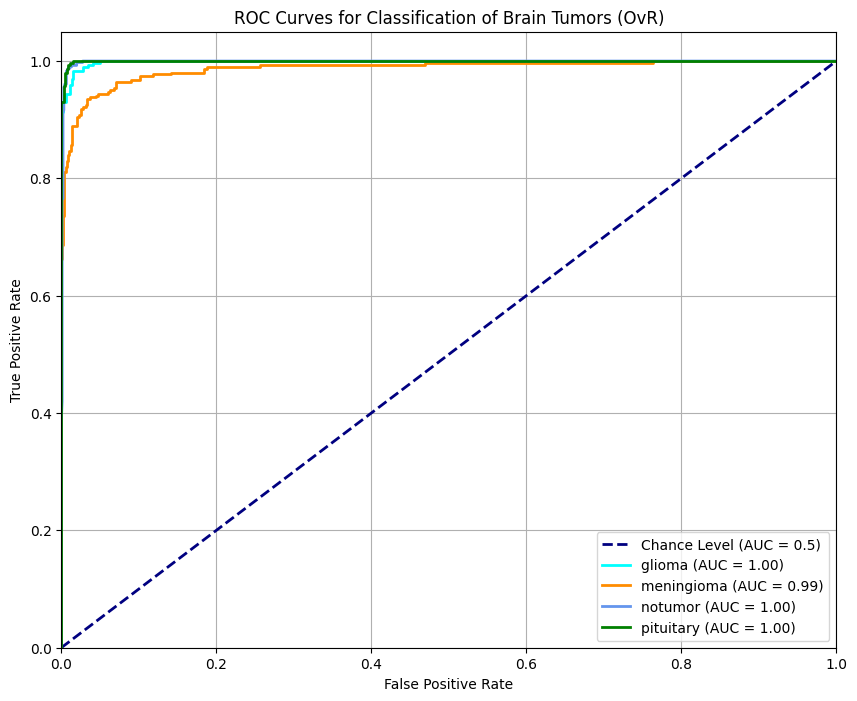

In [ ]:
#Roc-Auc, using one verse rest (OvR) method
try:
    # Calculate Micro-average ROC-AUC (OvR)
    roc_auc_micro_ovr = roc_auc_score(y_true, y_pred, multi_class='ovr', average='micro')
    print(f"Micro-average ROC-AUC (OvR): {roc_auc_micro_ovr:.4f}")

    # Calculate Macro-average ROC-AUC (OvR)
    roc_auc_macro_ovr = roc_auc_score(y_true, y_pred, multi_class='ovr', average='macro')
    print(f"Macro-average ROC-AUC (OvR): {roc_auc_macro_ovr:.4f}")

    # Calculate Weighted-average ROC-AUC (OvR)
    roc_auc_weighted_ovr = roc_auc_score(y_true, y_pred, multi_class='ovr', average='weighted')
    print(f"Weighted-average ROC-AUC (OvR): {roc_auc_weighted_ovr:.4f}")

    # Calculate ROC-AUC for each class (OvR)
    per_class_auc_ovr = roc_auc_score(y_true, y_pred, multi_class='ovr', average=None)
    print(f"Per-class ROC-AUC (OvR per class): {per_class_auc_ovr}")


except ValueError as e:
    print(f"\nError calculating ROC-AUC: {e}")
    print("Ensure test set includes samples from all classes for ROC-AUC calculation.")

# Plotting ROC curves for each class using One-vs-Rest (OvR) method
n_classes = y_true.shape[1]
plt.figure(figsize=(10, 8))
lw = 2 # Line width

# Plot the "chance level" diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Chance Level (AUC = 0.5)')

# Loop through each class to calculate and plot its OvR ROC curve
for i in range(n_classes):
    # Calculate ROC curve (FPR, TPR, thresholds) for class i vs. all others
    fpr, tpr, thresholds = roc_curve(y_true[:, i], y_pred[:, i])

    # Plot the ROC curve for the current class
    plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=lw,
             label=f'{class_names[i] if "class_names" in locals() and len(class_names) > i else i} (AUC = {per_class_auc_ovr[i]:.2f})') # Use per-class AUC calculated earlier for legend

#plot details
plt.xlim([0.0, 1.0]) # Set x-axis limits
plt.ylim([0.0, 1.05]) # Set y-axis limits
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Classification of Brain Tumors (OvR)') # Title of the plot
plt.legend(loc="lower right") # Add a legend
plt.grid(True) # Add a grid for readability
plt.show() # Display the plot


Confusion Matrix & Classification Report

In [ ]:
import pandas as pd

#confusion matrix
y_pred_classes = np.argmax(y_pred, axis=1) # Get predicted classes
y_true_classes = np.argmax(y_true, axis=1) # Get true classes

cm = confusion_matrix(y_true_classes, y_pred_classes) # Calculate confusion matrix

if 'class_names' in locals() and len(class_names) == cm.shape[0]:
    # Create DataFrame with class names as index (True Class) and columns (Predicted Class)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    # Print the DataFrame with explicit labels
    print("Confusion Matrix:")
    # Add extra print statements to clarify rows and columns
    print("Rows represent the TRUE class labels.")
    print("Columns represent the PREDICTED class labels.")
    print("-" * (len("Confusion Matrix:") + 2)) # Optional: Add separator line
    print(cm_df)
    print("-" * (len("Confusion Matrix:") + 2)) # Optional: Add separator line

else:
    # Fallback if class_names is not available or doesn't match dimensions
    print("Confusion Matrix (Class indices):")
    print(cm)
    print("\nNote: Class names not available or do not match matrix dimensions.")

#classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names) # Generate classification report
print("\nClassification Report:")
print(report) # Print classification report


Confusion Matrix:
Rows represent the TRUE class labels.
Columns represent the PREDICTED class labels.
-------------------
            glioma  meningioma  notumor  pituitary
glioma         279          19        0          2
meningioma       2         278       20          6
notumor          0           1      404          0
pituitary        1           3        1        295
-------------------

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.93      0.96       300
  meningioma       0.92      0.91      0.92       306
     notumor       0.95      1.00      0.97       405
   pituitary       0.97      0.98      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.95      0.96      1311
weighted avg       0.96      0.96      0.96      1311



Manual Testing of Model


--- Starting Manual Testing of Random Images from ALL Subdirectories ---
Getting image paths from all subdirectories within: Images 2/Testing
  Searching in subdirectory: glioma
  Searching in subdirectory: meningioma
  Searching in subdirectory: notumor
  Searching in subdirectory: pituitary
Selected 20 random images from the total pool for testing.

Processing image: Te-me_0108.jpg


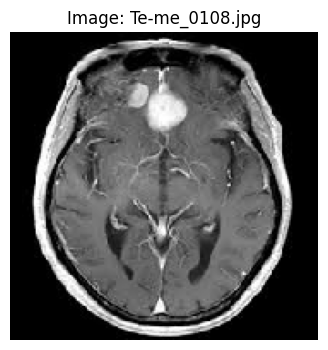

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
  Predicted Class: meningioma (Confidence: 0.7814)

Processing image: Te-no_0227.jpg


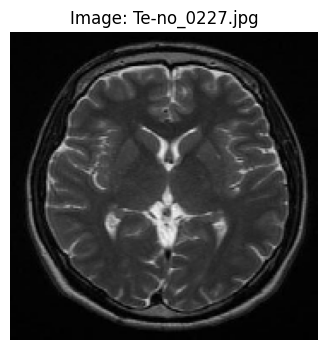

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
  Predicted Class: notumor (Confidence: 0.9998)

Processing image: Te-gl_0262.jpg


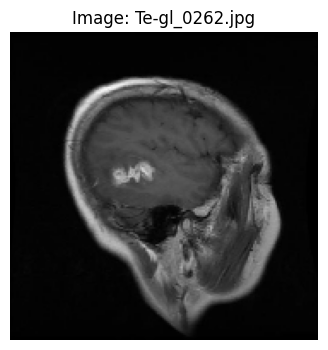

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
  Predicted Class: glioma (Confidence: 0.9727)

Processing image: Te-gl_0046.jpg


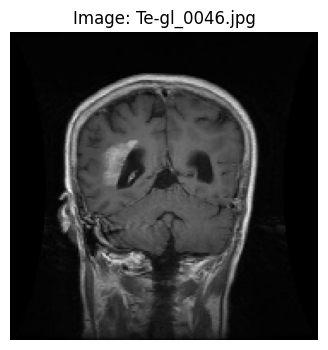

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
  Predicted Class: meningioma (Confidence: 0.6534)

Processing image: Te-pi_0110.jpg


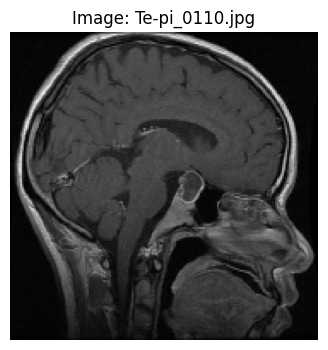

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
  Predicted Class: pituitary (Confidence: 0.9999)

Processing image: Te-piTr_0007.jpg


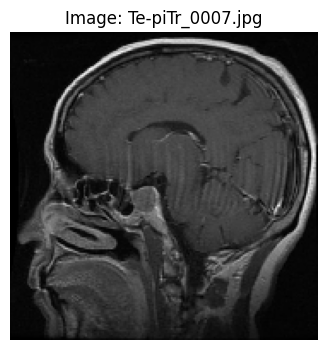

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
  Predicted Class: pituitary (Confidence: 0.9996)

Processing image: Te-no_0285.jpg


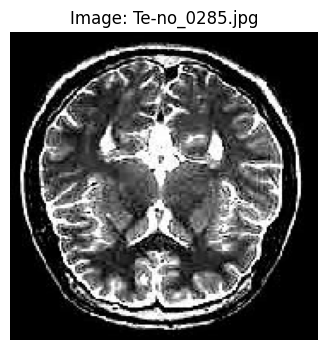

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
  Predicted Class: notumor (Confidence: 1.0000)

Processing image: Te-no_0352.jpg


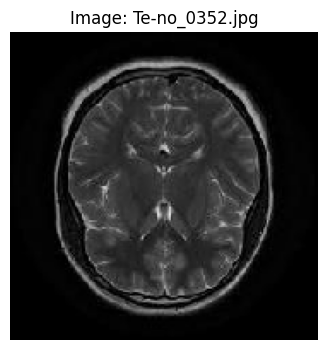

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
  Predicted Class: notumor (Confidence: 0.9957)

Processing image: Te-me_0037.jpg


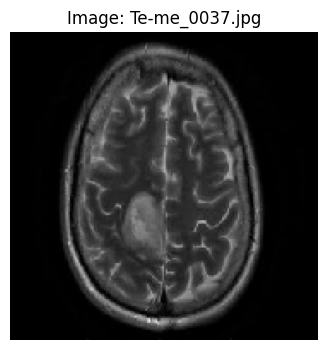

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
  Predicted Class: notumor (Confidence: 0.6176)

Processing image: Te-no_0273.jpg


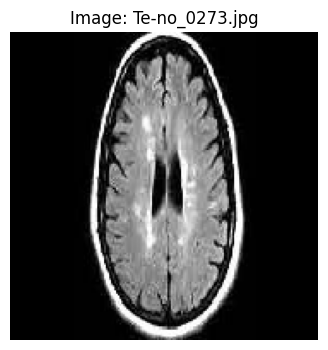

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
  Predicted Class: notumor (Confidence: 0.9910)

Processing image: Te-no_0278.jpg


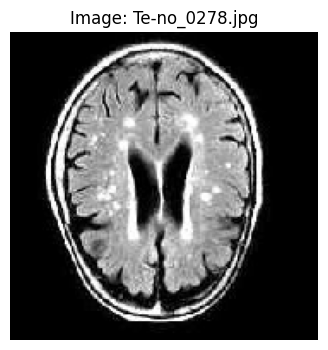

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
  Predicted Class: notumor (Confidence: 0.9910)

Processing image: Te-pi_0183.jpg


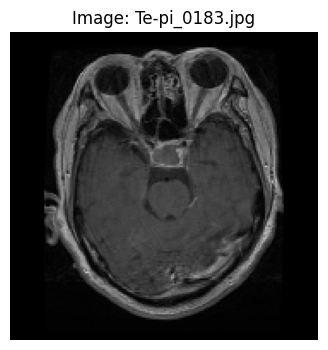

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
  Predicted Class: pituitary (Confidence: 0.9988)

Processing image: Te-no_0397.jpg


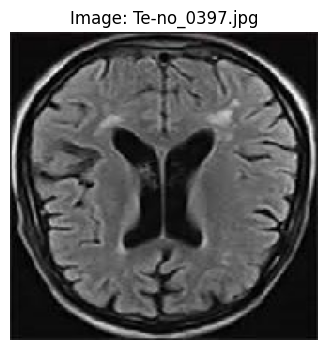

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
  Predicted Class: notumor (Confidence: 0.9103)

Processing image: Te-me_0210.jpg


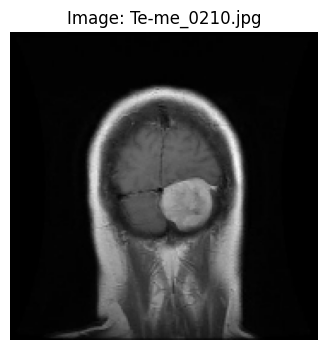

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
  Predicted Class: meningioma (Confidence: 0.9482)

Processing image: Te-piTr_0003.jpg


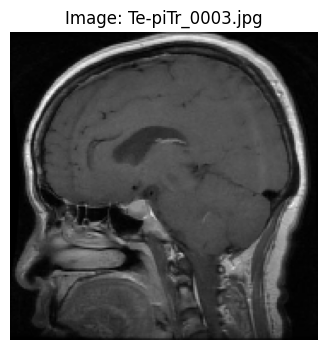

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
  Predicted Class: pituitary (Confidence: 0.9999)

Processing image: Te-me_0033.jpg


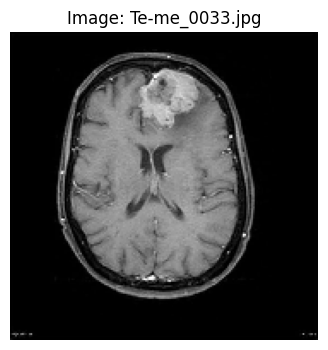

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
  Predicted Class: notumor (Confidence: 0.8206)

Processing image: Te-gl_0065.jpg


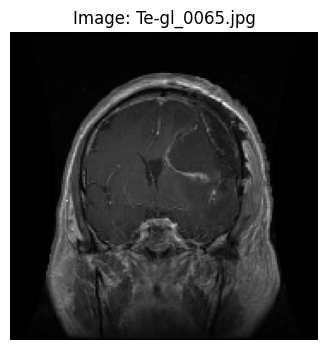

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
  Predicted Class: glioma (Confidence: 0.9850)

Processing image: Te-pi_0292.jpg


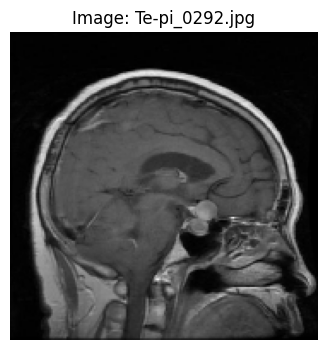

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
  Predicted Class: pituitary (Confidence: 0.9711)

Processing image: Te-gl_0288.jpg


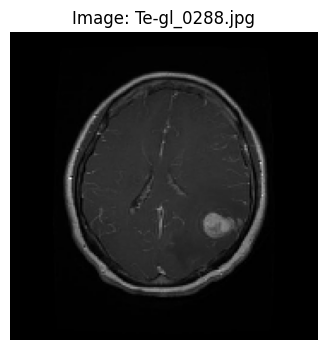

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
  Predicted Class: glioma (Confidence: 0.9818)

Processing image: Te-me_0150.jpg


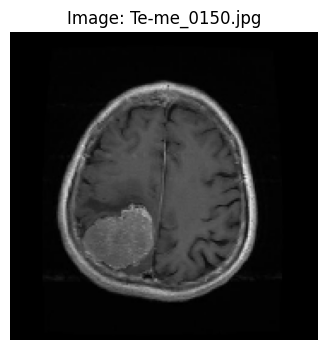

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
  Predicted Class: meningioma (Confidence: 0.8055)

--- Manual Testing Complete ---


In [17]:
import random
import os
# Add matplotlib, tensorflow, and numpy imports if they are not already at the top of your script
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf # Needed for tf.expand_dims and tf.argmax
import numpy as np # Needed for np.max


# --- Set the parent directory containing the class subfolders ---
image_paths_directory = "Images 2/Testing" # <--- Set this to the parent directory


num_random_images_to_test = 5
# --- Define the expected image file extension ---
image_extension = '.jpg' # <--- DEFINE THIS! Use '.png' or other extension if needed.

# Add a check to ensure essential variables are defined
try:
    img_height
    img_width
    class_names
    best_model # Using best_model as in your snippet, make sure this variable exists
except NameError:
    print("Error: Please define img_height, img_width, class_names, and best_model before running this code.")
    exit() # Exit if essential variables are not defined

print("\n--- Starting Manual Testing of Random Images from ALL Subdirectories ---")

# Use the parent directory path 
parent_directory_to_sample_from = image_paths_directory

# Define the number of random images you want to test from the total pool
num_random_images_to_test = 20 # <--- MODIFY THIS NUMBER

# Get Image Paths from ALL subdirectories using os module
print(f"Getting image paths from all subdirectories within: {parent_directory_to_sample_from}")
image_file_paths = [] # List to store all image file paths found

try:
    # List entries in the parent directory (expecting class folder names)
    for entry_name in os.listdir(parent_directory_to_sample_from):
        subdirectory_path = os.path.join(parent_directory_to_sample_from, entry_name)

        # Check if the entry is a directory (i.e., a class folder)
        if os.path.isdir(subdirectory_path):
            print(f"  Searching in subdirectory: {entry_name}")
            # If it's a directory, list files inside this subdirectory
            for file_name in os.listdir(subdirectory_path):
                full_file_path = os.path.join(subdirectory_path, file_name)

                # Check if the entry is a file AND ends with the desired image extension
                if os.path.isfile(full_file_path) and file_name.lower().endswith(image_extension.lower()):
                    image_file_paths.append(full_file_path) # Add the full path to our combined list

    # --- After checking all subdirectories, check if any image files were found in total ---
    if len(image_file_paths) == 0:
        print(f"Error: No files found matching *{image_extension} in any subdirectories within {parent_directory_to_sample_from}")
    else:
        # --- Select a random subset of images from the combined list ---
        # Ensure we don't ask for more images than are available in total
        random_images_to_process = random.sample(image_file_paths, min(num_random_images_to_test, len(image_file_paths)))

        print(f"Selected {len(random_images_to_process)} random images from the total pool for testing.")

        # --- Predict and Display for each random image ---
        for image_path in random_images_to_process:
            # The image_path here is already the full path string
            # Use os.path.basename() to get just the file name for printing/title
            print(f"\nProcessing image: {os.path.basename(image_path)}")

            # --- Load and preprocess the image for the model ---
            img = load_img(image_path, target_size=(img_height, img_width))
            img_array = img_to_array(img)
            img_array = tf.expand_dims(img_array, axis=0)

            # --- Display the image ---
            plt.figure(figsize=(4, 4))
            plt.imshow(img)
            plt.title(f"Image: {os.path.basename(image_path)}")
            plt.axis("off")
            plt.show()


            # --- Predict the class using the trained model ---
            predictions = best_model.predict(img_array)

            predicted_class_index = tf.argmax(predictions[0]).numpy()
            predicted_class_name = class_names[predicted_class_index]

            confidence = np.max(predictions[0])

            # --- Print the prediction result ---
            print(f"  Predicted Class: {predicted_class_name} (Confidence: {confidence:.4f})")
            # print("  All Probabilities:", predictions[0])


except FileNotFoundError:
    print(f"Error: The parent directory was not found at {parent_directory_to_sample_from}")
except ValueError as e:
    print(f"Error processing images: {e}. This could happen if essential variables are not defined.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


print("\n--- Manual Testing Complete ---")